# Importing Required Python Libraries 

In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import buttord
from scipy.signal import butter
from scipy.signal import freqz
from scipy.signal import lfilter
from scipy import stats
import math
from keras.models import load_model
import pickle

# Loading Data into a Python DataFrame

In [ ]:
df=pd.read_csv('final_input.csv')
df=df[['Gene','Label_cancer','length']]
df.head()

,Gene,Label_cancer,length
0,ATGAATGTTCTCCTGGGCAGCGTTGTGATCTTTGCCACCTTCGTGA...,0,345
1,CACCCGGAGAGCTGTGTCACCATGTGGGTCCCGGTTGTCTTCCTCA...,0,876
2,ATGTGGGCGCTTTGCTCGCTGCTGCGGTCCGCGGCCGGACGCACCA...,1,2908
3,GAATATTCTTCTGGAGCCCTTGGAGGGGCTCCAAACTGAGAGGGGA...,0,783
4,AGAGCTCCAGGGAGGGACCTGGGTAGAAGGAGAAGCCGGAAACAGC...,1,4050


In [ ]:
min(df.length)

345

# Signal Processing for DNA Sequence

In [ ]:
def signal_process(dna_seq):
  x=dna_seq
  l_dna=len(dna_seq)

  #Numerical Represenation of DNA Sequence .. Voss Mapping

  y=np.zeros((4,l_dna))
  nuc=['A','G','C','T']
  for i in range(4):
    for j in range(len(dna_seq)):
      if(dna_seq[j]==nuc[i]):
        y[i,j]='1'
      else:
        continue

  #Computing fast fourier transform for dna sequence

  fft_dna=np.zeros((4,l_dna))
  for i in range(4):
    fft_dna[i,:]=fft.fft(y[i,:])
 
  #Computing power spectral density for fast fourier transform result

  psd_dna=np.zeros((4,l_dna))
  for i in range(4):
    psd_dna[i,:]=(abs(fft_dna[i,:]))**2
  psdf=sum(psd_dna)

  #plt.plot(np.linspace(0,np.pi,(l_dna-1))/np.pi,psdf[1:])

  #Designing filter for power spectral density result

  wstop=0.4147
  wpass=0.301
  apass=0.5
  astop=40
  n,wc=buttord(wpass,wstop,apass,astop)
  b,a=butter(n,wc,btype='low')
  w,h=freqz(b,a,np.linspace(0,np.pi))

  #plt.plot(np.linspace(0,np.pi)/np.pi,20*np.log10(abs(h)))
  #Applying filter function

  fil_psd=lfilter(b,a,psdf[1:])
  #plt.plot(abs(fil_psd))
  return np.absolute(fil_psd)

# Applying signal processing for every sequence

In [ ]:
df['psd']=df['Gene'].apply(signal_process)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
df.head()

,Gene,Label_cancer,length,psd
0,ATGAATGTTCTCCTGGGCAGCGTTGTGATCTTTGCCACCTTCGTGA...,0,345,"[0.00013910627106226417, 0.0028873818909407587..."
1,CACCCGGAGAGCTGTGTCACCATGTGGGTCCCGGTTGTCTTCCTCA...,0,876,"[0.0004953742344268704, 0.011228439496897688, ..."
2,ATGTGGGCGCTTTGCTCGCTGCTGCGGTCCGCGGCCGGACGCACCA...,1,2908,"[0.000833485806067169, 0.017907586170981253, 0..."
3,GAATATTCTTCTGGAGCCCTTGGAGGGGCTCCAAACTGAGAGGGGA...,0,783,"[0.001064363552411308, 0.02266516999212322, 0...."
4,AGAGCTCCAGGGAGGGACCTGGGTAGAAGGAGAAGCCGGAAACAGC...,1,4050,"[0.009478791569196517, 0.19811994816658623, 1...."


# Feature Extraction

In [ ]:
def features(seq):
  l=[]

  #Extracting Features from our Filtered sequence.
  
  mean_psd=np.mean(seq)
  median_psd=np.median(seq)
  std_psd=np.std(seq)
  var_psd=np.var(seq)
  kurto_psd=sp.stats.kurtosis(seq)
  skew_psd=sp.stats.skew(seq)
  l.append(mean_psd)
  l.append(median_psd)
  l.append(std_psd)
  l.append(var_psd)
  l.append(kurto_psd)
  l.append(skew_psd)
  return np.array(l)

# Extracting Features from Every DNA Sequence

In [ ]:
df['features']=df['psd'].apply(features)

In [ ]:
df.head()

,Gene,Label_cancer,length,psd,features
0,ATGAATGTTCTCCTGGGCAGCGTTGTGATCTTTGCCACCTTCGTGA...,0,345,"[0.00013910627106226417, 0.0028873818909407587...","[122.55357933402277, 123.025780558618, 65.2393..."
1,CACCCGGAGAGCTGTGTCACCATGTGGGTCCCGGTTGTCTTCCTCA...,0,876,"[0.0004953742344268704, 0.011228439496897688, ...","[307.79099899497044, 299.97363540784846, 150.6..."
2,ATGTGGGCGCTTTGCTCGCTGCTGCGGTCCGCGGCCGGACGCACCA...,1,2908,"[0.000833485806067169, 0.017907586170981253, 0...","[1052.6715865141423, 1001.1649831735987, 533.6..."
3,GAATATTCTTCTGGAGCCCTTGGAGGGGCTCCAAACTGAGAGGGGA...,0,783,"[0.001064363552411308, 0.02266516999212322, 0....","[287.8357094683339, 278.2214954457475, 131.160..."
4,AGAGCTCCAGGGAGGGACCTGGGTAGAAGGAGAAGCCGGAAACAGC...,1,4050,"[0.009478791569196517, 0.19811994816658623, 1....","[1514.7698930147685, 1404.856192322019, 924.23..."


# Scaling of features

In [ ]:
def get_scale(x):
  return x/1000
df['features']=df['features'].apply(get_scale)

In [ ]:
df.head()

,Gene,Label_cancer,length,psd,features
0,ATGAATGTTCTCCTGGGCAGCGTTGTGATCTTTGCCACCTTCGTGA...,0,345,"[0.00013910627106226417, 0.0028873818909407587...","[0.12255357933402278, 0.123025780558618, 0.065..."
1,CACCCGGAGAGCTGTGTCACCATGTGGGTCCCGGTTGTCTTCCTCA...,0,876,"[0.0004953742344268704, 0.011228439496897688, ...","[0.3077909989949704, 0.29997363540784844, 0.15..."
2,ATGTGGGCGCTTTGCTCGCTGCTGCGGTCCGCGGCCGGACGCACCA...,1,2908,"[0.000833485806067169, 0.017907586170981253, 0...","[1.0526715865141423, 1.0011649831735987, 0.533..."
3,GAATATTCTTCTGGAGCCCTTGGAGGGGCTCCAAACTGAGAGGGGA...,0,783,"[0.001064363552411308, 0.02266516999212322, 0....","[0.2878357094683339, 0.2782214954457475, 0.131..."
4,AGAGCTCCAGGGAGGGACCTGGGTAGAAGGAGAAGCCGGAAACAGC...,1,4050,"[0.009478791569196517, 0.19811994816658623, 1....","[1.5147698930147686, 1.404856192322019, 0.9242..."


# Splitting Dataset for Training and Testing

In [ ]:
import tensorflow
from tensorflow import keras
from sklearn.model_selection import train_test_split

temp=[]
l=df.features.values
for i in l:
  temp.append(list(i))
arr=np.array(temp)
#df1=pd.DataFrame(l,columns=['mean','median','std','variance','kurtosis','skewness'])

In [ ]:
arr.shape

(25, 6)

In [ ]:
df1=pd.DataFrame(arr)

In [ ]:
df1.head()

,0,1,2,3,4,5
0,0.122554,0.123026,0.065239,4.256168,0.003015,0.001011
1,0.307791,0.299974,0.150614,22.684475,0.002697,0.000770
2,1.052672,1.001165,0.533634,284.765722,0.004861,0.001207
3,0.287836,0.278221,0.131160,17.202973,0.000669,0.000390
4,1.514770,1.404856,0.924237,854.214209,0.045313,0.004186


In [ ]:
df1.columns=['mean','median','std','variance','kurtosis','skewness']

In [ ]:
df1.head()

,mean,median,std,variance,kurtosis,skewness
0,0.122554,0.123026,0.065239,4.256168,0.003015,0.001011
1,0.307791,0.299974,0.150614,22.684475,0.002697,0.000770
2,1.052672,1.001165,0.533634,284.765722,0.004861,0.001207
3,0.287836,0.278221,0.131160,17.202973,0.000669,0.000390
4,1.514770,1.404856,0.924237,854.214209,0.045313,0.004186


In [ ]:
df1['Label_cancer']=df['Label_cancer']

In [ ]:
df1.head()

,mean,median,std,variance,kurtosis,skewness,Label_cancer
0,0.122554,0.123026,0.065239,4.256168,0.003015,0.001011,0
1,0.307791,0.299974,0.150614,22.684475,0.002697,0.000770,0
2,1.052672,1.001165,0.533634,284.765722,0.004861,0.001207,1
3,0.287836,0.278221,0.131160,17.202973,0.000669,0.000390,0
4,1.514770,1.404856,0.924237,854.214209,0.045313,0.004186,1


In [ ]:
x=df1.drop('Label_cancer',axis='columns')
y=df1.Label_cancer

In [ ]:
x

,mean,median,std,variance,kurtosis,skewness
0,0.122554,0.123026,0.065239,4.256168,0.003015,0.001011
1,0.307791,0.299974,0.150614,22.684475,0.002697,0.000770
2,1.052672,1.001165,0.533634,284.765722,0.004861,0.001207
3,0.287836,0.278221,0.131160,17.202973,0.000669,0.000390
4,1.514770,1.404856,0.924237,854.214209,0.045313,0.004186
5,3.259777,3.019626,2.426038,5885.658341,0.192603,0.010513
6,0.178710,0.175381,0.085459,7.303312,0.000069,0.000263
7,0.369177,0.357546,0.160156,25.650003,-0.000092,0.000329
8,0.891521,0.824431,0.588046,345.798443,0.036114,0.004130
9,1.044642,0.975148,0.588248,346.035774,0.015884,0.002380


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=25)

# Neural Network Construction

In [ ]:
model=keras.Sequential([
    keras.layers.Dense(12,input_shape=(6,),activation='relu'),
    
    keras.layers.Dense(1,activation='sigmoid')
])

# Neural Network compilation

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Neural Network Training

In [ ]:
model.fit(x_train,y_train,epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 21ms/step - loss: 0.4279 - accuracy: 0.8500
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4278 - accuracy: 0.8500
Epoch 3/500
1/1 [==============================] - 0s 15ms/step - loss: 0.4276 - accuracy: 0.8500
Epoch 4/500
1/1 [==============================] - 0s 16ms/step - loss: 0.4275 - accuracy: 0.8500
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4274 - accuracy: 0.8500
Epoch 6/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4273 - accuracy: 0.8500
Epoch 7/500
1/1 [==============================] - 0s 16ms/step - loss: 0.4271 - accuracy: 0.8500
Epoch 8/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4270 - accuracy: 0.8500
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4269 - accuracy: 0.8500
Epoch 10/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4268 - accuracy: 0.8500
Epoch 11/500
1/1 [=

# Neural Network Testing

In [ ]:
model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 21ms/step - loss: 0.1291 - accuracy: 1.0000


[0.12910765409469604, 1.0]

In [ ]:
x_test[:]

,mean,median,std,variance,kurtosis,skewness
7,0.369177,0.357546,0.160156,25.650003,-0.000092,0.000329
4,1.514770,1.404856,0.924237,854.214209,0.045313,0.004186
10,3.344203,3.118374,1.986515,3946.243452,0.057827,0.004626
11,1.836432,1.739328,1.005624,1011.279371,0.031539,0.003268
18,0.341330,0.328949,0.154185,23.772917,0.001539,0.000612


In [ ]:
y_test[:]

7     0
4     1
10    1
11    1
18    0
Name: Label_cancer, dtype: int64

# Prediction of Testing Data

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred=model.predict(x_test)
y_pred=[i[0] for i in y_pred]
print(y_pred)
y_test


1/1 [==============================] - 0s 74ms/step
[0.2705405, 0.98618126, 1.0, 0.9949306, 0.26735172]


7     0
4     1
10    1
11    1
18    0
Name: Label_cancer, dtype: int64

#Performance Evaluation Parameters

#Calculating True Positive Rate and False Positive rates

In [ ]:
roc_df=pd.DataFrame({'actual':y_test,'prediction':y_pred})
roc_df

,actual,prediction
7,0,0.270541
4,1,0.986181
10,1,1.000000
11,1,0.994931
18,0,0.267352


In [ ]:
thresh=0.5

In [ ]:
tp=0
fp=0
fn=0
tn=0

for index,instance in roc_df.iterrows():
  actual=instance['actual']
  prediction=instance['prediction']
  
  if(prediction>=thresh):
    prediction_class=1
  else:
    prediction_class=0

  if(prediction_class==1 and actual==1):
    tp=tp+1
  elif(prediction_class==0 and actual==1):
    fn=fn+1
  elif(prediction_class==1 and actual==0):
    fp=fp+1
  elif(prediction_class==0 and actual==0):
    tn=tn+1

print(tp,fp,fn,tn)
tpr=tp/(tp+fn)
fpr=fp/(tn+fp)
print(tpr,fpr)

3 0 0 2
1.0 0.0


#Plot ROC Curve

In [ ]:
tholds=np.array(list(range(0,106,5)))/100
tholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05])

In [ ]:
roc_points=[]
for thresh in tholds:
  tp=0
  fp=0
  fn=0
  tn=0
  for index,instance in roc_df.iterrows():
    actual=instance['actual']
    prediction=instance['prediction']
  
    if(prediction>=thresh):
      prediction_class=1
    else:
      prediction_class=0

    if(prediction_class==1 and actual==1):
      tp=tp+1
    elif(prediction_class==0 and actual==1):
      fn=fn+1
    elif(prediction_class==1 and actual==0):
      fp=fp+1
    elif(prediction_class==0 and actual==0):
      tn=tn+1

  #print(tp,fp,fn,tn)
  tpr=tp/(tp+fn)
  fpr=fp/(tn+fp)
  roc_points.append([tpr,fpr])
  #print(tpr,fpr)

In [ ]:
len(roc_points)

22

In [ ]:
pivot=pd.DataFrame(roc_points,columns=['x','y'])

In [ ]:
len(tholds)

22

In [ ]:
pivot['thresholds']=tholds
pivot.head()

,x,y,thresholds
0,1.0,1.0,0.00
1,1.0,1.0,0.05
2,1.0,1.0,0.10
3,1.0,1.0,0.15
4,1.0,1.0,0.20


Text(0.5, 1.0, 'ROC Curve')

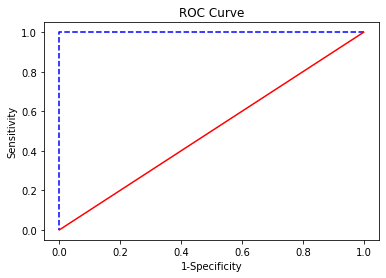

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pivot.y,pivot.x,ls='--',color='blue')
plt.plot([0,1],color='red')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')

#Calculate AUC Value

In [ ]:
auc=round(abs(np.trapz(pivot.x,pivot.y)),4)

In [ ]:
auc

1.0

#Confusion Matrix Visualization

[0.2705405, 0.98618126, 1.0, 0.9949306, 0.26735172]
[0, 1, 1, 1, 0]


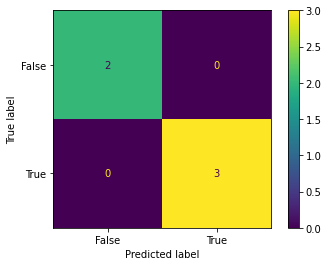

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
print(y_pred)
y_pred_confusion=[]
for i in y_pred:
  if(i<=0.5):
    y_pred_confusion.append(0)
  else:
    y_pred_confusion.append(1)
print(y_pred_confusion)

confusion_matrix = confusion_matrix(y_test, y_pred_confusion)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#Classification Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report=classification_report(y_test,y_pred_confusion)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

